In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from SPARQLWrapper import SPARQLWrapper, JSON
import json

In [2]:
def sparql_to_dataframe(endpoint, query):
    """
    Convert SPARQL results into a Pandas DataFrame.
    Credit: https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    
    cols = results['head']['vars']
    out = []
    for row in results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)


In [3]:
endpoint = 'https://covidontheweb.inria.fr/sparql'

In [24]:
query = '''
select ?date ?deaths ?hospitalized ?intensive from <http://ns.inria.fr/covid19/graph/opencovid19fr>
where {
    ?a  a schema:SpecialAnnouncement;
        schema:datePosted ?date;
        schema:spatialCoverage [
            a                    wd:Q6465; # department
            schema:identifier    "06";
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty wdt:P1120; # number of deaths
            schema:measuredValue ?deaths
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty wdt:P8049; # number of hospitalized cases
            schema:measuredValue ?hospitalized
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty <http://ns.inria.fr/covid19/property/noCasesIntensiveCare>;
            schema:measuredValue ?intensive
        ].
} order by ?date
'''

In [25]:
%time df = sparql_to_dataframe(endpoint, query)

Wall time: 392 ms


In [26]:
# Prepare data
df.deaths = df.deaths.astype(int)
df.hospitalized = df.hospitalized.astype(int)
df.intensive = df.intensive.astype(int)
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)

df.shape
df.head()

,deaths,hospitalized,intensive
date,,,
2020-03-18,2,25,1
2020-03-19,2,33,5
2020-03-20,4,43,7
2020-03-21,6,46,7
2020-03-22,7,45,8


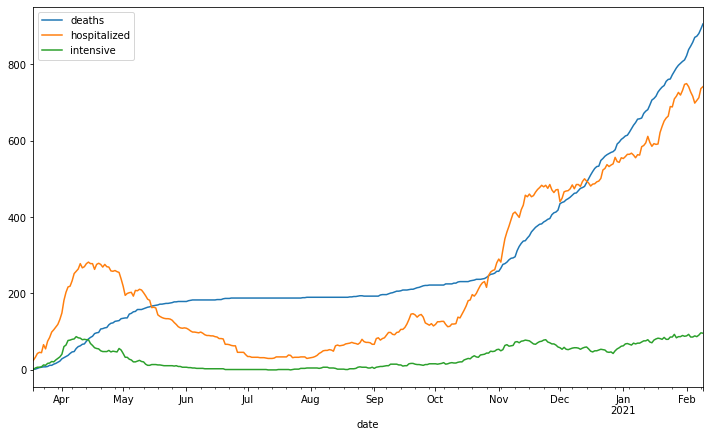

In [27]:
fig, ax = plt.subplots(figsize=(12,7))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
df.plot(ax=ax)
plt.show()